In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import gc

%load_ext autoreload
%autoreload 2

In [4]:
# прописывем нужные нам пути
dir_project = 'git/proj_news_viz/nlp' # путь к проекту

PATH = os.path.join(os.getenv('HOME'), dir_project)
sys.path.append(PATH)

In [5]:
import pandas as pd
import numpy as np

import time
from datetime import datetime
from pprint import pprint

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from news_viz.models.topic_modeling.gensim import fit_tm_gensim
from news_viz.visualization.visualize import plot_metrics

---
читаем данные

In [7]:
df = pd.read_csv(f'{PATH}/data/interim/news_lenta-cleaned-lemmatize.csv.gz', compression='gzip')
print(df.shape)
df.sample(2)

(674580, 2)


,url,lemma_text
51136,https://lenta.ru/news/2017/06/06/bags/,афганский герат возле мечеть прогреметь взрыв ...
211683,https://lenta.ru/news/2013/10/15/avioneta/,адель оказаться королева британский певица аде...


In [8]:
# преобразуем текст в список токенов
df['lemma_text_list'] = df.lemma_text.apply(lambda x: x.split())
df.sample(2)

,url,lemma_text,lemma_text_list
188583,https://lenta.ru/news/2014/07/23/assets/,вернуть акционер миллиард доллар планировать в...,"[вернуть, акционер, миллиард, доллар, планиров..."
478249,https://lenta.ru/news/2007/08/16/bishkek/,украинский коммунист пообещать допустить союз ...,"[украинский, коммунист, пообещать, допустить, ..."


In [9]:
# проверим и удалим пустые записи и дубликаты
df.dropna(inplace=True)
df.lemma_text.drop_duplicates(inplace=True)

print(f'df.shape = {df.shape}')
df.isnull().sum()

df.shape = (674580, 3)


url                0
lemma_text         0
lemma_text_list    0
dtype: int64

---
### LDA

Для работы с LDA нам нужно подготовить 2 объекта:

1. словарь, в котором каждому слову присваивается уникальный id

In [10]:
%%time
dictionary = corpora.Dictionary(df.lemma_text_list)

CPU times: user 1min 59s, sys: 13.5 s, total: 2min 13s
Wall time: 2min 18s


In [11]:
len(dictionary)

460587

In [12]:
dictionary[0]

'ансворт'

2. список преобразованных текстов ("мешок слов" или tf-idf)

In [13]:
%%time
corpus = [dictionary.doc2bow(doc) for doc in df.lemma_text_list]

CPU times: user 1min 44s, sys: 1min 13s, total: 2min 58s
Wall time: 3min 39s


In [14]:
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 3), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)]]


In [15]:
# или можем посмотреть более человеческим взглядом
print([[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('ансворт', 2), ('британский', 2), ('верна', 1), ('видеть', 1), ('внутри', 1), ('вскоре', 1), ('вход', 2), ('вызволять', 1), ('глубокий', 1), ('грот', 1), ('дайвера', 2), ('день', 1), ('десять', 1), ('детский', 1), ('дождь', 1), ('живой', 1), ('завалить', 1), ('засунуть', 1), ('затопить', 3), ('заявить', 1), ('идея', 1), ('илона', 2), ('инцидент', 1), ('исчезновение', 1), ('июль', 1), ('июнь', 1), ('камень', 1), ('километр', 1), ('команда', 1), ('крутой', 1), ('маск', 3), ('маска', 1), ('место', 1), ('миллиардер', 1), ('мини-субмарина', 1), ('морпех', 1), ('назвать', 2), ('найти', 1), ('один', 1), ('операция', 1), ('оппонент', 1), ('ответ', 1), ('ответить', 1), ('отделять', 1), ('отметить', 1), ('педофил', 2), ('пещера', 3), ('пиар-ход', 1), ('план', 1), ('по-настоящему', 1), ('подлодка', 1), ('поздний', 1), ('пойти', 1), ('посоветовать', 1), ('пошлый', 1), ('пропасть', 1), ('раскритиковать', 1), ('ребёнок', 3), ('резка', 1), ('свобода', 1), ('свой', 1), ('сидеть', 1), ('сначала', 1)

---
обучаем

In [ ]:
%%time

steps = list(range(20,40+1,5))
meta_gensim_models = fit_tm_gensim(corpus=corpus,
                                   dictionary=dictionary,
                                   text=df.lemma_text_list,
                                   range_topics=steps,
                                   passes=10,
                                   per_word_topics=True)

#topic 20 ..........


In [294]:
pprint(meta_gensim_models)

{20: {'coherence': 0.5144337986855156,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x44389fd68>,
      'perplexity': -8.164091658083976,
      'time_fit': {'hours': 1, 'min': 30, 'sec': 5418}},
 25: {'coherence': 0.5531484856093514,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x45751b588>,
      'perplexity': -8.12692651882661,
      'time_fit': {'hours': 1, 'min': 37, 'sec': 5821}},
 30: {'coherence': 0.5585719330067274,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x4512092e8>,
      'perplexity': -8.11692132947281,
      'time_fit': {'hours': 1, 'min': 44, 'sec': 6283}},
 35: {'coherence': 0.5719526325244266,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x43059d908>,
      'perplexity': -8.094560849077032,
      'time_fit': {'hours': 1, 'min': 56, 'sec': 6963}},
 40: {'coherence': 0.5717171541475855,
      'model': <gensim.models.ldamulticore.LdaMulticore object at 0x45f386b00>,
      'perplexity':

----
нарисуем графики метрик

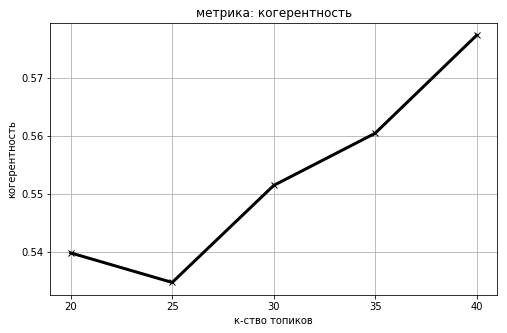

In [295]:
# когерентность
coherence_list = [meta_gensim_models[i]['coherence'] for i in meta_gensim_models.keys()]
plot_metrics(range_topics=steps, metric=coherence, title='когерентность')

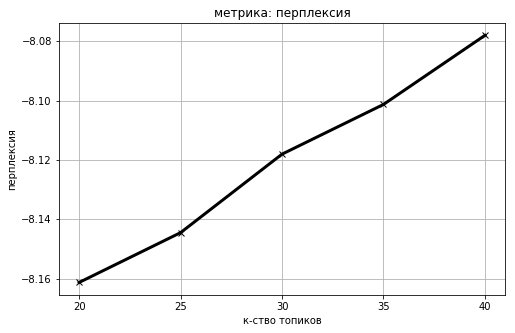

In [296]:
# перплексия
coherence_list = [meta_gensim_models[i]['perplexity'] for i in meta_gensim_models.keys()]
plot_metrics(range_topics=steps, metric=perplexity, title='перплексия')

---
выберем на наше вмение лучшую модель и посмотрим на кластера 

In [307]:
select_topics = 40

best_model = meta_gensim_models[select_topics]['model']

# проверяем правильную выбрали ли модель
print(best_model.num_topics)

40


In [ ]:
# %%time

# best_model.save('./tm-gensim-t40/t40.model')

# best_model = LdaMulticore.load('./tm-gensim-t40/t40.model')
# best_model.num_topics

In [17]:
pprint(best_model.print_topics(num_words=15))

[(23,
  '0.022*"год" + 0.017*"школа" + 0.015*"русский" + 0.013*"театр" + '
  '0.011*"студент" + 0.010*"университет" + 0.010*"язык" + 0.010*"российский" + '
  '0.009*"александр" + 0.009*"имя" + 0.008*"образование" + '
  '0.008*"государственный" + 0.008*"культура" + 0.007*"институт" + '
  '0.007*"владимир"'),
 (19,
  '0.051*"самолёт" + 0.021*"аэропорт" + 0.014*"вертолёт" + 0.013*"борт" + '
  '0.013*"пассажир" + 0.012*"авиакомпания" + 0.011*"экипаж" + '
  '0.010*"находиться" + 0.010*"рейс" + 0.009*"пилот" + 0.008*"судно" + '
  '0.008*"полёт" + 0.008*"сообщать" + 0.007*"катастрофа" + 0.007*"воздушный"'),
 (1,
  '0.032*"россия" + 0.019*"заявить" + 0.016*"путин" + 0.013*"слово" + '
  '0.012*"глава" + 0.011*"президент" + 0.011*"вопрос" + 0.010*"владимир" + '
  '0.010*"российский" + 0.010*"сказать" + 0.009*"отметить" + 0.009*"министр" + '
  '0.008*"встреча" + 0.008*"страна" + 0.007*"подчеркнуть"'),
 (21,
  '0.031*"выбор" + 0.021*"процент" + 0.020*"кандидат" + 0.017*"голос" + '
  '0.015*"избира

In [25]:
# отобразим наши кластеры
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'pyLDAvis/pyLDAvis_gensim.html')

vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
32    -0.110232  0.067962       1        1  4.975406
1     -0.004000  0.196812       2        1  4.765985
29    -0.028669  0.180333       3        1  4.608528
14     0.100407  0.051852       4        1  4.188845
9      0.024932 -0.010862       5        1  3.949961
28     0.080870  0.000865       6        1  3.620364
25    -0.171444 -0.188870       7        1  3.439729
27     0.019561  0.108903       8        1  3.271204
7     -0.018993  0.166733       9        1  3.223405
4     -0.107896  0.051215      10        1  2.966640
12    -0.179532 -0.191215      11        1  2.930828
38    -0.143429  0.029872      12        1  2.840254
5      0.048726 -0.066175      13        1  2.797727
36    -0.065183  0.002607      14        1  2.734186
24     0.078557  0.095561      15        1  2.635607
31     0.001411  0.123610      16        1  2.583144
11     0.151879 -0.019803      17        1  2.564463
26    -0.219053 -0.193520      18        1  2.539868
6     -0.115953  0.196486      19        1  2.496232
15     0.171202 -0.093860      20        1  2.436275
8     -0.229548 -0.136833      21        1  2.423390
16    -0.076487 -0.006081      22        1  2.255481
0      0.140300 -0.062452      23        1  2.151335
19    -0.120118 -0.112100      24        1  2.033244
30     0.195033 -0.075471      25        1  2.026812
17     0.025452 -0.026755      26        1  2.006545
3      0.011333 -0.027100      27        1  1.960482
37    -0.106968  0.138185      28        1  1.960448
13     0.173946 -0.099962      29        1  1.960376
33    -0.023179 -0.080133      30        1  1.737014
34     0.042660 -0.054672      31        1  1.708437
18     0.113632 -0.119083      32        1  1.664763
10     0.002825  0.082003      33        1  1.622719
23     0.066319  0.020199      34        1  1.602375
21     0.068941  0.024842      35        1  1.553705
35     0.141004 -0.104414      36        1  1.496302
39    -0.001085  0.068399      37        1  1.352089
22     0.165387 -0.062721      38        1  1.272177
20    -0.034078  0.103457      39        1  0.914083
2     -0.068532  0.022186      40        1  0.729570, topic_info=      Category           Freq           Term          Total  loglift  logprob
term                                                                         
1408   Default  180552.000000        украина  180552.000000  30.0000  30.0000
169    Default  223565.000000            сша  223565.000000  29.0000  29.0000
770    Default  246161.000000        процент  246161.000000  28.0000  28.0000
100    Default  236203.000000         доллар  236203.000000  27.0000  27.0000
95     Default  947940.000000            год  947940.000000  26.0000  26.0000
152    Default  411729.000000         россия  411729.000000  25.0000  25.0000
117    Default  187591.000000        миллион  187591.000000  24.0000  24.0000
715    Default  199321.000000       компания  199321.000000  23.0000  23.0000
166    Default  235475.000000         страна  235475.000000  22.0000  22.0000
1311   Default   88303.000000        самолёт   88303.000000  21.0000  21.0000
2803   Default   90332.000000          фильм   90332.000000  20.0000  20.0000
336    Default  264791.000000     российский  264791.000000  19.0000  19.0000
1260   Default  111062.000000        военный  111062.000000  18.0000  18.0000
502    Default  107726.000000          акция  107726.000000  17.0000  17.0000
214    Default   89839.000000           матч   89839.000000  16.0000  16.0000
2039   Default   72330.000000     украинский   72330.000000  15.0000  15.0000
347    Default  141344.000000   американский  141344.000000  14.0000  14.0000
422    Default  125530.000000       миллиард  125530.000000  13.0000  13.0000
143    Default  143910.000000      президент  143910.000000  12.0000  12.0000
515    Default  180047.000000         москва  180047.000000  11.0000  11.0000
153    Default 

---
поприсваиваем каждой записи наиболее вероятный кластер

In [40]:
def format_topics_sentences(ldamodel, corpus, texts):
    """
    Создаёт DdataFrame с информацией о самом распространённом топике для каждого текста.

    Параметры:
    ldamodel : Натренированная LDA модель
    corpus : Gensim corpus
    texts : []
        Список текстов

    Returns:
    --------
    sent_topics_df : pd.DataFrame

    """
    sent_topics_df = pd.DataFrame()
    # Словарь с топиками и топ-словами для них.
    words_per_topic = {j: [i[0] for i in ldamodel.show_topic(j)] for j in range(ldamodel.num_topics)}

    for i, row in enumerate(ldamodel[corpus]):
        if ldamodel.per_word_topics == False:
            # Самый распространённый топик в каждом тексте
            row_topics = sorted(row, key=lambda x: x[1], reverse=True)

        else:
            row_topics = sorted(row[0], key=lambda x: x[1], reverse=True)

        # Номер топика и его доля
        topic_num, prop_topic = row_topics[0]
        topic_keywords = ', '.join([word for word in words_per_topic[topic_num] if word in texts[i]])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                                               ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return sent_topics_df

In [43]:
%%time
df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=df.lemma_text_list)

CPU times: user 8h 47min 53s, sys: 1h 21min 46s, total: 10h 9min 39s
Wall time: 10h 11min 20s


In [45]:
print(df_topic_sents_keywords.shape)
df_topic_sents_keywords.head(3)

(674580, 4)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,lemma_text_list
0,9.0,0.3893,"свой, заявить","[илона, маск, назвать, педофил, спасать, ребён..."
1,24.0,0.3700,"год, доллар, нефть, россия","[сша, задуматься, распечатывание, нефтяной, ре..."
2,26.0,0.4305,"задержать, автомобиль, сотрудник, полицейский,...","[празднование, победа, чм, франция, закончитьс..."
